In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data
dataset = pd.read_csv("data/AB_NYC_2019.csv")

In [4]:
dataset.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
dataset.drop(['id', 'name', 'host_id', 'host_name'], axis = 1, inplace=True)

In [6]:
dataset['last_review'] = pd.DatetimeIndex(dataset.last_review).astype("int64") // 10**9 #изменить формат времени
dataset.loc[dataset.last_review < 0, "last_review"] = 0

In [7]:
dataset.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                           0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [8]:
#заполнить недостающие данные средним числом ревью в месяц
mean = dataset['reviews_per_month'].mean()
dataset['reviews_per_month'].fillna(mean, inplace=True)
#ИЛИ заполнить нулями недостающие данные dataset = dataset.fillna(0)

Text(0.5, 1.0, 'Распределение цены')

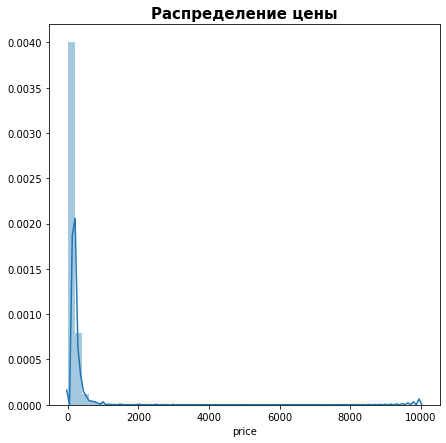

In [77]:
plt.figure(figsize=(7,7))
sns.distplot(dataset['price'])
plt.title("Распределение цены",size=15, weight='bold')

In [9]:
'''''
Иногда при построении регрессии целесообразно преобразовать зависимую переменную у. 
Прогнозирование частот является довольно распространенной задачей, 
и преобразование log(у + 1) часто помогает.
'''''
dataset['price_log'] = np.log(dataset['price']+1)
dataset.drop(['price'], axis = 1, inplace=True)

Text(0.5, 1.0, 'Логарифмическое распределение цены')

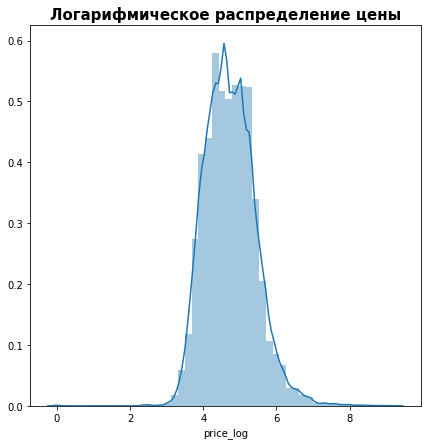

In [79]:
plt.figure(figsize=(7,7))
sns.distplot(dataset['price_log'])
plt.title("Логарифмическое распределение цены", size=15, weight='bold')

In [10]:
#Сохранение датасета с One hot encoding перед изменением
dataset_dummies = pd.get_dummies(dataset.drop(['price_log','neighbourhood_group'], axis = 1))

In [12]:
#Series.cat.codes: return Series of codes as well as the index.
def change_with_cat_codes(df, list_of_columns):
    for column in list_of_columns:
        df[column] = df[column].astype('category').cat.codes
    return df

Text(0.5, 1, 'Корреляция между признаками')

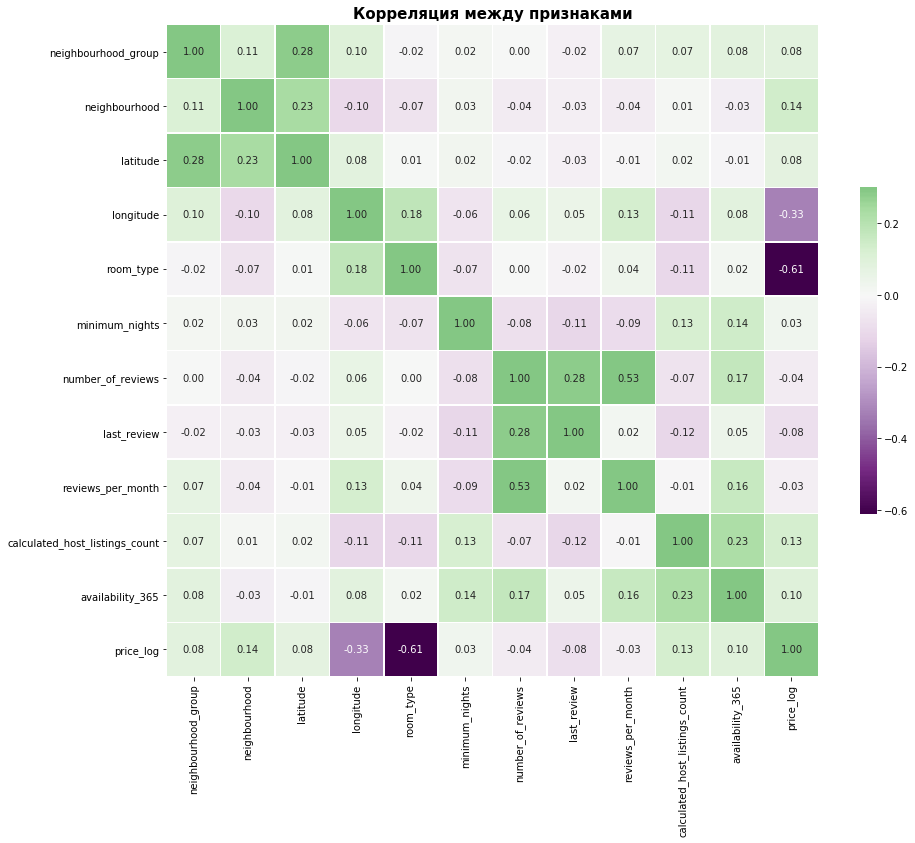

In [13]:
'''
Для более стабильной регрессии следуюет убирать признаки, которые имеют
высокую корреляцию с зависимой переменной у, так как при высокой корреляции
увеличивается дисперсия вектора весов.
https://towardsdatascience.com/why-exclude-highly-correlated-features-when-building-regression-model-34d77a90ea8e
'''
plt.figure(figsize=(15,12))
#чтобы построить матрицу корреляции, необходимо изменить категориальные данные
corr = change_with_cat_codes(dataset, ['neighbourhood_group','neighbourhood', 'room_type']).corr(method='pearson') 
sns.heatmap(corr, annot=True, fmt='.2f', cmap='PRGn', vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(12, 0))
plt.title("Корреляция между признаками", size=15, weight='bold')

In [14]:
x, y = dataset.iloc[:,:-1], dataset.iloc[:,-1]

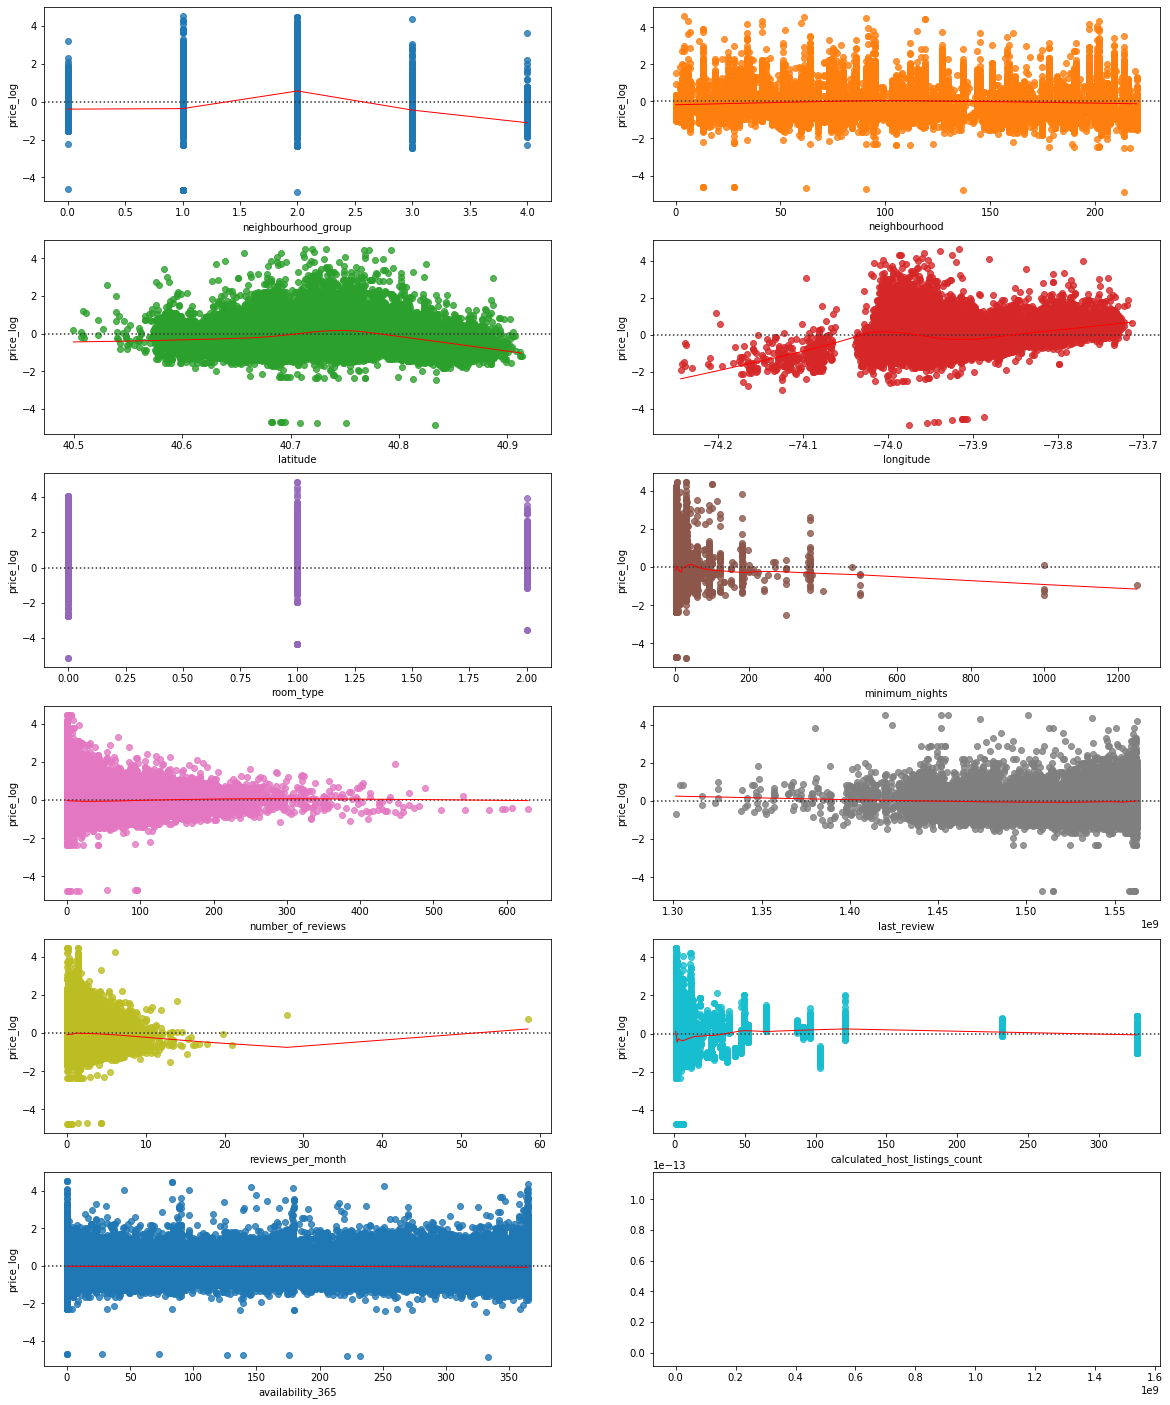

In [139]:
'''
Residual - это разница между тем, что отображается на диаграмме рассеяния в определенной точке,
и тем, что, согласно уравнению регрессии, «должно быть нанесено» в этой конкретной точке. 
Residual plot - это график, который показывает остатки по вертикальной оси и независимую переменную по горизонтальной оси.
Если точки случайным образом рассредоточены вокруг горизонтальной оси, для данных подходит модель линейной регрессии;
в противном случае более подходящей является нелинейная модель.
'''
f, axes = plt.subplots(6, 2, figsize=(20, 25))
sns.residplot(x.iloc[:,0], y, lowess=True, ax=axes[0, 0], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,1], y, lowess=True, ax=axes[0, 1], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,2], y, lowess=True, ax=axes[1, 0], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,3], y, lowess=True, ax=axes[1, 1], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,4], y, lowess=True, ax=axes[2, 0], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,5], y, lowess=True, ax=axes[2, 1], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,6], y, lowess=True, ax=axes[3, 0], line_kws={'color': 'red', 'lw': 1})
x.loc[x.last_review == 0, "last_review"] = None #не отображать на графике нулевые значение
sns.residplot(x.iloc[:,7], y, lowess=True, ax=axes[3, 1], dropna=True, line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,8], y, lowess=True, ax=axes[4, 0], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,9], y, lowess=True, ax=axes[4, 1], line_kws={'color': 'red', 'lw': 1})
sns.residplot(x.iloc[:,10], y, lowess=True, ax=axes[5, 0], line_kws={'color': 'red', 'lw': 1})

In [101]:
'''
Мультиколлинеарность — наличие линейной зависимости между объясняющими переменными (факторами) регрессионной модели.
Один из способов нахождения мультиколлинеарности - нахождение собственных значений (eigenvalues) корреляционной матрицы.
Малые и нулевые значения собственных значений свидетельствует о наличии мультиколлинеарности.
'''
eigenvalues, eigenvectors = np.linalg.eig(corr)
eigenvalues

array([1.98728835, 1.67260393, 1.433898  , 1.30266155, 0.32331589,
       0.40040146, 0.66396078, 0.69634246, 0.75752515, 0.86957577,
       0.93457842, 0.95784824])

In [172]:
dataset_dummies.head()

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,1,9,1539907200,0.210000,6,365,0,1,...,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,1,45,1558396800,0.380000,2,355,0,0,...,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,3,0,0,1.373221,1,365,0,0,...,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,1,270,1562284800,4.640000,1,194,0,1,...,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,10,9,1542585600,0.100000,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [54]:
'''
Применение StandardScaler гарантирует, что для каждого признака среднее будет равно 0,
а дисперсия будет равна 1, в результате чего все признаки будут иметь один и тот же масштаб.
'''
def scale_and_split(x, y):
    scaler = StandardScaler().fit(x)
    dataset_scaled = scaler.transform(x)
    X_train, X_test, y_train, y_test = train_test_split(dataset_scaled, y, random_state=0)
    return X_train, X_test, y_train, y_test, dataset_scaled

In [55]:
X_train, X_test, y_train, y_test, dataset_scaled = scale_and_split(x, y)

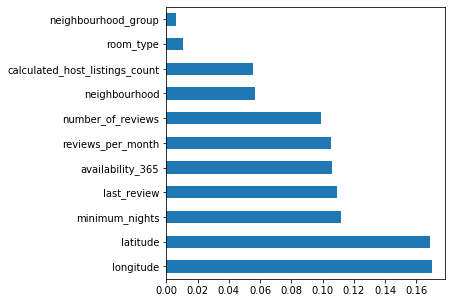

In [23]:
'''
С помощью ExtraTreesClassifier можно построить график значимости признаков и проанализировать его.
LabelEncoder необходим для преобразавания чисел в y в целые числа, так как используется классификатор. 
'''
label_enc = LabelEncoder()
feature_model = ExtraTreesClassifier(n_estimators=50)
feature_model.fit(X_train, label_enc.fit_transform(y_train))
feature_importences = pd.Series(feature_model.feature_importances_, index=dataset.iloc[:,:-1].columns)
plt.figure(figsize=(5,5))
feature_importences.nlargest(X_train.shape[1]).plot(kind='barh')

In [50]:
'''
Можно создать две модели: с признаками, имеюшими наименьшую значимость и без.
'''
dataset_without = dataset.drop(['neighbourhood_group', 'room_type'], axis=1)
x_1 = dataset_without.iloc[:,:-1]

In [44]:
#Нахождение оптимальных параметров для каждого вида регресии.
param_grid = {'alpha': [1,0.1,0.01,0.001,0.0001,10,100]}
grid_search = GridSearchCV(Ridge(), param_grid).fit(X_train, y_train)
print("Лучшие параметры: {}".format(grid_search.best_params_))
print("Лучший результат: {}".format(grid_search.best_score_))

Лучшие параметры: {'alpha': 100}
Лучший результат: 0.46296558448656505


In [45]:
grid_search = GridSearchCV(Lasso(), param_grid).fit(X_train, y_train)
print("Лучшие параметры: {}".format(grid_search.best_params_))
print("Лучший результат: {}".format(grid_search.best_score_))

Лучшие параметры: {'alpha': 0.001}
Лучший результат: 0.4629956666030679


In [41]:
grid_search = GridSearchCV(ElasticNet(), param_grid).fit(X_train, y_train)
print("Лучшие параметры: {}".format(grid_search.best_params_))
print("Лучший результат: {}".format(grid_search.best_score_))

Лучшие параметры: {'alpha': 0.001}
Лучший результат: 0.46298203347995154


In [51]:
'''
Добавление полиномиальных признаков
'''
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False).fit(x_1)
X_poly = poly.transform(x_1)

In [63]:
reg = LinearRegression()
regScores = cross_val_score(reg, X_poly, y)
print('Без двух признаков + полиномиальные')
print("Результат перекрестной проверки: {}".format(regScores))
print("Средняя правильность перекрестной проверки: {}".format(regScores.mean()))

print('\nСтандартные признаки')
regScores = cross_val_score(reg, dataset_scaled, y)
print("Результат перекрестной проверки: {}".format(regScores))
print("Средняя правильность перекрестной проверки: {}".format(regScores.mean()))

Без двух признаков + полиномиальные
Результат перекрестной проверки: [ 0.02484061  0.13897293 -1.21432145]
Средняя правильность перекрестной проверки: -0.3501693006495357

Стандартные признаки
Результат перекрестной проверки: [0.42112999 0.43516943 0.48319923]
Средняя правильность перекрестной проверки: 0.4464995528778683


In [66]:
scaler = StandardScaler().fit(dataset_dummies)
dataset_scaled_d = scaler.transform(dataset_dummies)

In [67]:
'''
Использование полиномальных признаков не дало результата,
теперь сравнение разных видов кодирования классов
'''
reg = LinearRegression()
regScores = cross_val_score(reg, dataset_scaled, y)
print('Коды')
print("Результат перекрестной проверки: {}".format(regScores))
print("Средняя правильность перекрестной проверки: {}".format(regScores.mean()))

print('\nOne hot encoding')
regScores = cross_val_score(reg, dataset_scaled_d, y)
print("Результат перекрестной проверки: {}".format(regScores))
print("Средняя правильность перекрестной проверки: {}".format(regScores.mean()))

Коды
Результат перекрестной проверки: [0.42112999 0.43516943 0.48319923]
Средняя правильность перекрестной проверки: 0.4464995528778683

One hot encoding
Результат перекрестной проверки: [-9.25319029e+25 -6.92260540e+23 -7.14486963e+25]
Средняя правильность перекрестной проверки: -5.489095324111977e+25


In [71]:
reg = Ridge(alpha=100)
regScores = cross_val_score(reg, dataset_scaled, y)
print('Кодирование')
print("Результат перекрестной проверки: {}".format(regScores))
print("Средняя правильность перекрестной проверки: {}".format(regScores.mean()))

print('\nOne hot encoding')
regScores = cross_val_score(reg, dataset_scaled_d, y)
print("Результат перекрестной проверки: {}".format(regScores))
print("Средняя правильность перекрестной проверки: {}".format(regScores.mean()))

Кодирование
Результат перекрестной проверки: [0.42158482 0.43524503 0.4837611 ]
Средняя правильность перекрестной проверки: 0.44686365017536994

One hot encoding
Результат перекрестной проверки: [0.48581927 0.51406993 0.53119439]
Средняя правильность перекрестной проверки: 0.5103611963404445


In [72]:
'''
В принципе с One hot encoding лучше результат, но время тратится больше
'''
reg = Lasso(alpha=0.001)
regScores = cross_val_score(reg, dataset_scaled_d, y)
print("Результат перекрестной проверки: {}".format(regScores))
print("Средняя правильность перекрестной проверки: {}".format(regScores.mean()))

Результат перекрестной проверки: [0.48663378 0.51459565 0.53872481]
Средняя правильность перекрестной проверки: 0.5133180813393107


In [73]:
reg = ElasticNet(alpha=0.001)
regScores = cross_val_score(reg, dataset_scaled_d, y)
print("Результат перекрестной проверки: {}".format(regScores))
print("Средняя правильность перекрестной проверки: {}".format(regScores.mean()))

Результат перекрестной проверки: [0.48627725 0.51461244 0.5345096 ]
Средняя правильность перекрестной проверки: 0.5117997655901912
